In [55]:
# Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Text Processing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# PyTorch for Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Gensim for Word Vectors
import os
import gensim.downloader as api
from gensim.models import KeyedVectors


# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
# Read the CSV file into a DataFrame
def read_csv(path):
    df = pd.read_csv(path)
    return df


###  Data Preprocess

In [57]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()

    # Replace '\\' with a space
    text = re.sub(r'\\', ' ', text)

    # Remove unnecessary symbols, keep only words and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text


In [58]:

def create_vocabulary(df, text_column, min_df=5, max_df=0.8):
    # Create the vocabulary
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    X = vectorizer.fit_transform(df[text_column])
    vocabulary = vectorizer.get_feature_names_out()

    return vocabulary 


##   A) Word2Vec Model:


In [59]:
model_path = './model/word2vec-google-news-300.model'

# Check if the model file exists
if not os.path.exists(model_path):
    # If the model does not exist, download it
    print("Downloading model...")
    model = api.load('word2vec-google-news-300')
    
    # Create the directory if it does not exist
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    
    # Save the model to your local disk
    print("Saving model to disk...")
    model.save(model_path)

# Load the model from disk
print("Loading model from disk...")
word2vec_model = KeyedVectors.load(model_path, mmap='r')

print("Model is ready to use.")


Loading model from disk...
Model is ready to use.


In [60]:
def get_embeddings(text, model, vocabulary):
    # Tokenize the text. This is a simple split on spaces; consider using a better tokenizer.
    tokens = text.split()

    # Initialize an empty list to store embeddings
    embeddings = []

    # Determine the dimensionality of the embeddings
    embedding_dim = model.vector_size

    # For each token, get its embedding if it's in the model's vocabulary
    for token in tokens:
        if token in model.key_to_index and token in vocabulary:
            embedding = model[token]
        else:
            # Append a zero vector for tokens not in the model's vocabulary
            embedding = [0] * embedding_dim
        embeddings.append(embedding)
    
    return embeddings


In [61]:

def average_embeddings(text, model, vocabulary):
    embeddings = get_embeddings(text, model, vocabulary)  # Assuming get_embeddings is defined as before
    if embeddings:
        # Convert embeddings list to a NumPy array for vectorized operations
        embeddings_array = np.array(embeddings)
        
        # Compute the average embedding
        average_embedding = np.mean(embeddings_array, axis=0)
        return average_embedding
    else:
        # Return a zero vector if no words in the model's vocabulary
        return np.zeros(model.vector_size)

###  NNLayers

In [62]:
class SimpleNN(nn.Module):
    def __init__(self, input_feature_dim, output_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_feature_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, output_classes)     # Output layer
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU to the output of the first layer
        x = self.fc2(x)  # No activation needed here; will use nn.CrossEntropyLoss
        return x
 

### Training

In [63]:
def train_model(model, X, y, batch_size=32, epochs=10, learning_rate=0.001):
    # Set the loss function
    loss_function = nn.CrossEntropyLoss()

    # Set the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Calculate total number of batches
    num_batches = int(np.ceil(X.size(0) / batch_size))

    # Training loop
    for epoch in range(epochs):
        total_loss = 0

        # Shuffle the data at the beginning of each epoch
        permutation = torch.randperm(X.size(0))

        for i in range(num_batches):
            # Calculate batch start and end indices
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, X.size(0))

            # Create batches
            indices = permutation[start_idx:end_idx]
            batch_X, batch_y = X[indices], y[indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Calculate loss
            loss = loss_function(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print average loss for the epoch
        print(f"Epoch {epoch+1}, Average Loss: {total_loss / num_batches}")
    
    return model

###  Testing and Evaluating:


In [64]:
def do_eval(model, X_test, y_test):
    
    # Ensure the model is in evaluation mode
    model.eval()

    predictions = []

    # No need to track gradients for validation
    with torch.no_grad():
        for input in X_test:
            # Add an extra dimension to input to represent a batch size of 1
            input_batch = input.unsqueeze(0)

            # Make predictions
            outputs = model(input_batch)

            # Convert outputs to predictions by applying argmax
            pred = torch.argmax(outputs, dim=1).item()
            predictions.append(pred)


 
    
        # Calculate metrics
        accuracy = accuracy_score(y_test, predictions)
        macro_f1 = f1_score(y_test, predictions, average='macro')
        
        print(f'Accuracy: {accuracy:.4f}, Macro F1 Score: {macro_f1:.4f}')
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()
    

    return predictions


In [65]:
df =  read_csv('../data/train.csv')

In [66]:
df['processed'] = df['text'].apply(preprocess)


In [67]:
vocabulary = create_vocabulary(df, 'processed')


In [68]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [69]:
def give_data(df, word2vec_model, vocabulary):
    X = np.array([average_embeddings(text, word2vec_model, vocabulary) for text in df['processed']])
    y = df['label'].to_numpy()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    # y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

In [70]:
X_train, y_train = give_data(train_df, word2vec_model, vocabulary)

In [71]:
X_val, y_val = give_data(val_df, word2vec_model, vocabulary)

In [72]:
nn_model = SimpleNN(input_feature_dim=300, output_classes= 4)

In [73]:
nn_model = train_model(nn_model, X_train, y_train,epochs=20)

Epoch 1, Average Loss: 1.2699471950531005
Epoch 2, Average Loss: 0.8635815036296844
Epoch 3, Average Loss: 0.5952168053388596
Epoch 4, Average Loss: 0.4986568802595139
Epoch 5, Average Loss: 0.4548050975799561
Epoch 6, Average Loss: 0.4292993858456612
Epoch 7, Average Loss: 0.40991211324930193
Epoch 8, Average Loss: 0.3949777328968048
Epoch 9, Average Loss: 0.3849732577800751
Epoch 10, Average Loss: 0.37301293909549715
Epoch 11, Average Loss: 0.3590143766999245
Epoch 12, Average Loss: 0.35258748739957807
Epoch 13, Average Loss: 0.34326022684574126
Epoch 14, Average Loss: 0.33535695254802705
Epoch 15, Average Loss: 0.32811534389853475
Epoch 16, Average Loss: 0.31801969349384307
Epoch 17, Average Loss: 0.3132400706410408
Epoch 18, Average Loss: 0.30437002450227735
Epoch 19, Average Loss: 0.29811708495020867
Epoch 20, Average Loss: 0.2926612874865532


Accuracy: 0.8575, Macro F1 Score: 0.8582


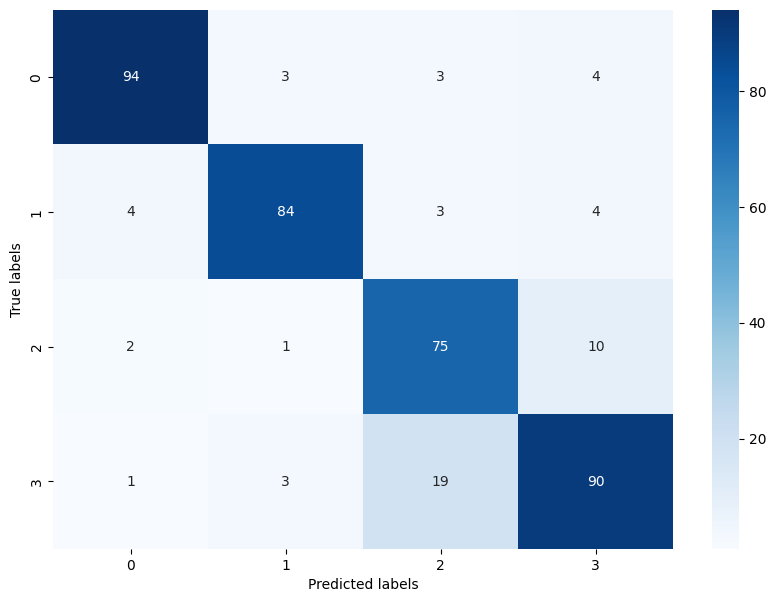

In [74]:
predictions = do_eval(nn_model, X_val, y_val)

In [75]:
print(classification_report(y_val, predictions))


              precision    recall  f1-score   support

           0       0.93      0.90      0.92       104
           1       0.92      0.88      0.90        95
           2       0.75      0.85      0.80        88
           3       0.83      0.80      0.81       113

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



### doing prediction on Test set

In [76]:
df_test = read_csv('../data/test.csv')

In [77]:
df_test['processed'] = df_test['text'].apply(preprocess)


In [78]:
X_test, y_test = give_data(df_test, word2vec_model, vocabulary)


Accuracy: 0.8360, Macro F1 Score: 0.8365


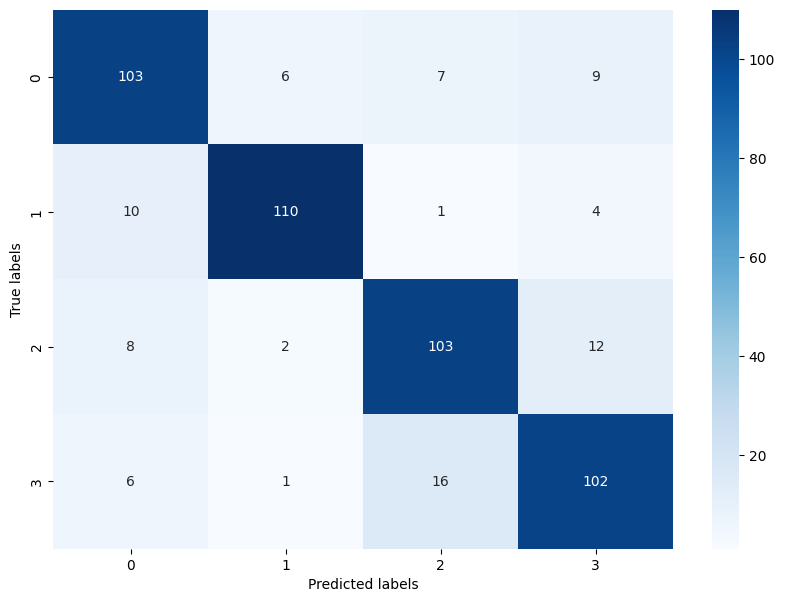

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       125
           1       0.92      0.88      0.90       125
           2       0.81      0.82      0.82       125
           3       0.80      0.82      0.81       125

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



In [79]:
NN_predictions = do_eval(nn_model, X_test, y_test)
print(classification_report(y_test, NN_predictions))

In [80]:
def do_saving(df, predictions, name):
    # Append the predictions to your test dataframe
    df['preds'] = predictions

    # Save to CSV
    df[['index','text','label','preds']].to_csv(f'./output/{name}', index=False)

In [81]:
do_saving(df_test, predictions = NN_predictions, name="w2v_test.csv")

##  B) Recurrent Neural Networks (RNN)

###  Data Batching

In [82]:

class DataFrameDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['processed']
        label = self.dataframe.iloc[idx]['label']
        tokens = self.tokenizer(text, self.max_len)  # Ensure this returns a flat list of token IDs
        
        # If tokens are more than max_len, truncate them
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        
        # If tokens are less than max_len, pad them
        padded_tokens = tokens + [0] * (self.max_len - len(tokens))
        
        return torch.tensor(padded_tokens, dtype=torch.long), torch.tensor(int(label), dtype=torch.long)


In [83]:
def create_word_index(vocabulary):
    word_index = {word: idx + 1 for idx, word in enumerate(vocabulary)}  # Start indexing from 1
    return word_index

word_index = create_word_index(vocabulary)


In [84]:

def simple_tokenizer(text, max_len):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert tokens to their indices in word_index
    token_ids = [word_index.get(token, 0) for token in tokens]  # Using 0 for unknown words
    
    # Truncate or pad the token_ids list to the max_len
    if len(token_ids) > max_len:
        token_ids = token_ids[:max_len]  # Truncate
    else:
        token_ids += [0] * (max_len - len(token_ids))  # Pad with integer zeroes
    
    return token_ids


In [85]:
# Example usage:
max_len = 100  # Define the maximum sequence length
batch_size = 32  # Define batch size


train_dataset = DataFrameDataset(train_df, tokenizer=simple_tokenizer, max_len=max_len)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [86]:
val_dataset = DataFrameDataset(val_df, tokenizer=simple_tokenizer, max_len=max_len)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [87]:
test_dataset = DataFrameDataset(df_test, tokenizer=simple_tokenizer, max_len=max_len)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


###  RNNModel

#### VanillaRNN

In [88]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional, pretrained_embeddings):
        super(VanillaRNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        # text dim: [batch size, sent_length]
        embedded = self.dropout(self.embedding(text))
        # embedded dim: [batch size, sent_length, emb_dim]
        
        output, _ = self.rnn(embedded)
        # output dim: [batch size, sent_length, hidden_dim * num_directions]
        
        # Get the average of the RNN outputs
        avg_pool = torch.mean(output, dim=1)
        # avg_pool dim: [batch size, hidden_dim * num_directions]
        
        return self.fc(avg_pool)


#### LSTM

In [89]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional, pretrained_embeddings):
        super(LSTMModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        # text dim: [batch size, sent_length]
        embedded = self.dropout(self.embedding(text))
        # embedded dim: [batch size, sent_length, emb_dim]
        
        output, (hidden, cell) = self.lstm(embedded)
        # output dim: [batch size, sent_length, hidden_dim * num_directions]
        
        # Get the average of the LSTM outputs
        avg_pool = torch.mean(output, dim=1)
        # avg_pool dim: [batch size, hidden_dim * num_directions]
        
        return self.fc(avg_pool)


In [90]:


def train_model(model, train_loader, epochs=10, lr=0.001):
    # Move model to the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Loss function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0
        
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            
            predictions = model(texts)  # Forward pass
            loss = criterion(predictions, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            
            total_loss += loss.item()  # Accumulate loss

        avg_train_loss = total_loss / len(train_loader)  # Calculate average loss
        
        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}')
            
    print('Training complete.')


In [101]:

def do_prediction(model, valid_loader, name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # No need for loss calculation if you're only doing predictions
    all_predicted_labels = []
    all_true_labels = []

    with torch.no_grad():
        for texts, labels in valid_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            predictions = model(texts)
            _, predicted_labels = torch.max(predictions, 1)
            
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    macro_f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')
    
    print(f'Accuracy: {accuracy:.4f}, Macro F1 Score: {macro_f1:.4f}')
    
    # Plot confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(name)
    plt.show()
    
    return all_predicted_labels


In [92]:
embedding_dim = 300 # Assuming you are using 300-dimensional Word2Vec embeddings

# Initialize the embedding matrix with zeros, size + 1 for the zero padding
vocab_size = len(word_index) + 1  # word_index starts from 1, and +1 for padding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [93]:
# Initialize the matrix with zeros
for word, i in word_index.items():
    # Check if the word is in the word2vec model
    if word in word2vec_model.key_to_index:
        # Retrieve the corresponding vector
        embedding_vector = word2vec_model[word]
        # Assign it to the corresponding row in the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # Optionally, initialize words not found in Word2Vec with random vectors
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

In [94]:

# Convert the embedding matrix to a tensor
pretrained_embeddings = torch.FloatTensor(embedding_matrix)

In [95]:
# Initialize your models with the appropriate parameters
hidden_dim = 256 # Size of RNN/LSTM hidden layer
output_dim = 4 # Number of output classes
bidirectional = True # Using bidirectional RNN/LSTM
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional, pretrained_embeddings)


In [96]:
# Initialize your models with the appropriate parameters
hidden_dim = 256 # Size of RNN/LSTM hidden layer
output_dim = 4 # Number of output classes
bidirectional = True # Using bidirectional RNN/LSTM
rnn_model = VanillaRNN(vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional, pretrained_embeddings)


In [97]:

# Train LSTM Model
train_model(lstm_model, train_data_loader, epochs=10, lr=0.001)


Epoch 1: Train Loss = 1.1811
Epoch 2: Train Loss = 0.8896
Epoch 3: Train Loss = 0.7568
Epoch 4: Train Loss = 0.7647
Epoch 5: Train Loss = 0.6929
Epoch 6: Train Loss = 0.6472
Epoch 7: Train Loss = 0.5774
Epoch 8: Train Loss = 0.5518
Epoch 9: Train Loss = 0.6274
Epoch 10: Train Loss = 0.5760
Training complete.


In [98]:

# Train Vanilla RNN Model
train_model(rnn_model, train_data_loader, epochs=10, lr=0.001)


Epoch 1: Train Loss = 1.1883
Epoch 2: Train Loss = 1.0775
Epoch 3: Train Loss = 0.8740
Epoch 4: Train Loss = 0.7992
Epoch 5: Train Loss = 0.6928
Epoch 6: Train Loss = 0.5877
Epoch 7: Train Loss = 0.5996
Epoch 8: Train Loss = 0.5431
Epoch 9: Train Loss = 0.5452
Epoch 10: Train Loss = 0.5295
Training complete.


Accuracy: 0.7920, Macro F1 Score: 0.7940


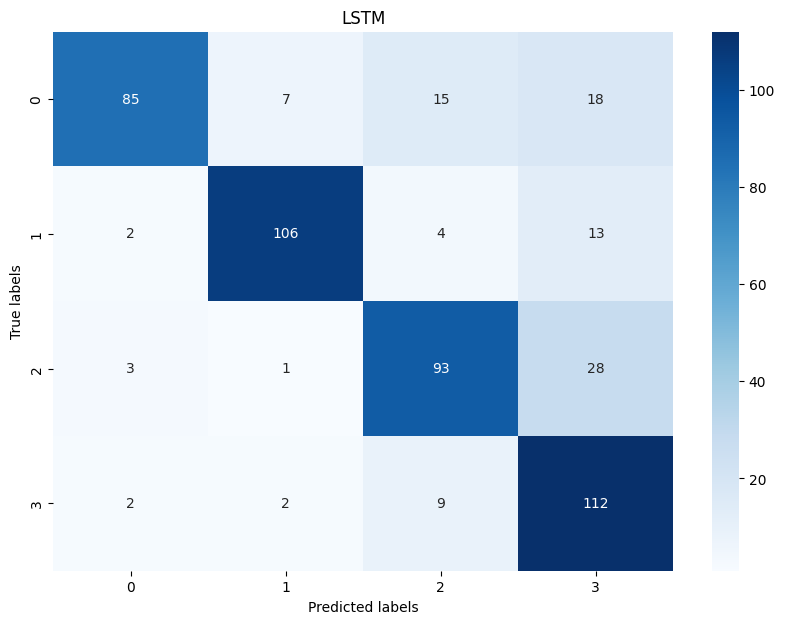

In [102]:
lstm_predictions = do_prediction(lstm_model, test_data_loader, "LSTM")
do_saving(df= df_test, predictions = lstm_predictions, name="lstm_test.csv")

Accuracy: 0.8080, Macro F1 Score: 0.8072


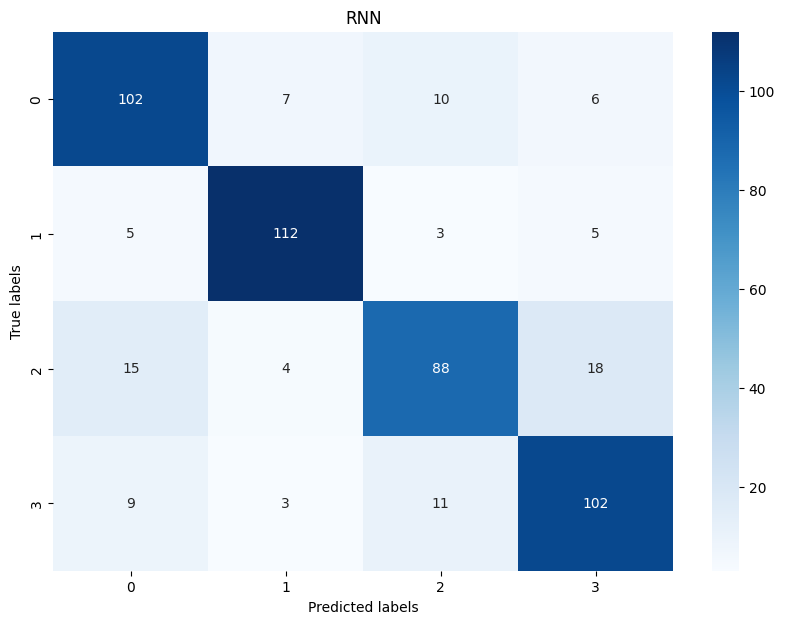

In [103]:
rnn_predictions = do_prediction(rnn_model, test_data_loader, "RNN")
do_saving(df= df_test,predictions = rnn_predictions, name="rnn__test.csv")